# Helicóptero de Bancada para disciplina de Controle e Aplicações

## Preparação

In [622]:
# Bibliotecas
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive
from scipy.optimize import minimize
from IPython.display import Latex
from tbcontrol.symbolic import routh
from scipy.integrate import solve_ivp
import pandas as pd

import control as ct
s = ct.tf('s')

from seaborn import color_palette
colors = color_palette()

In [623]:
# Definição dos símbolos
m_c, m_m, a, l, L, K, g = sp.symbols('m_c m_m a l L K g')
epsilon, alpha, theta = sp.symbols('epsilon alpha theta')
d_epsilon, d_alpha, d_theta = sp.symbols('d_epsilon d_alpha d_theta')
dd_epsilon, dd_alpha, dd_theta = sp.symbols('dd_epsilon dd_alpha dd_theta')
V_D, V_E = sp.symbols('V_D V_E')
M_P_x, M_P_y, M_P_z = sp.symbols('M_P_x M_P_y M_P_z')
rho, C_D, U, S, beta = sp.symbols('rho C_D U S beta')
x1, x2, x3, x4, x5, x6 = sp.symbols('x1 x2 x3 x4 x5 x6') 
u1, u2 = sp.symbols('u1 u2')                              
w1, w2, w3 = sp.symbols('w1 w2 w3')                        
epsilon_linha, alpha_linha, theta_linha = sp.symbols('epsilon_linha alpha_linha theta_linha')
s = sp.symbols('s')

I = sp.eye(6)

In [624]:
# Parametros
params = {
    m_c: 1.565,
    m_m: 0.355,
    l: 0.45,
    L: 0.64,
    K: 0.5839,
    g: 9.81,
    a: 0.275,
    rho: 1.225,
    C_D: 1,
    S: 0.00196,
    beta: 10*np.pi/180,
    U: 5,
    #epsilon_linha: 4*np.pi/180,
    #alpha_linha: 1*np.pi/180,
    theta_linha: 2*np.pi/180
}

## Modelagem Matemática

In [625]:
# Vetores unitários
i = sp.Matrix([1, 0, 0])
j = sp.Matrix([0, 1, 0])
k = sp.Matrix([0, 0, 1])

# Matrizes de rotação
R_x = sp.Matrix([
    [1, 0, 0],
    [0, sp.cos(epsilon), -sp.sin(epsilon)],
    [0, sp.sin(epsilon), sp.cos(epsilon)]
])

R_y = sp.Matrix([
    [sp.cos(alpha), 0, sp.sin(alpha)],
    [0, 1, 0],
    [-sp.sin(alpha), 0, sp.cos(alpha)]
])

R_z = sp.Matrix([
    [sp.cos(theta), -sp.sin(theta), 0],
    [sp.sin(theta), sp.cos(theta), 0],
    [0, 0, 1]
])

R = R_x * R_y * R_z

# Vetores de posição
rc = -l * j
r = L * j
rd = r + a * i
re = r - a * i

# Momentos de inércia
Ixx = m_c*l**2 + 2*m_m*L**2
Iyy = 2*m_m*a**2
Izz = m_c*l**2 + 2*m_m*(a**2 + L**2)
J = sp.diag(Ixx, Iyy, Izz)

M_P = M_P_x*i + M_P_y*j + M_P_z*k

# Velocidade e aceleração angular
omega = d_epsilon*i + d_alpha*j + d_theta*k
d_omega = dd_epsilon*i + dd_alpha*j + dd_theta*k

# Pesos
Pc = R * (m_c * g * k)
Pm = R * (m_m * g * k)

# Equilíbrio de forças
Fc = Pc
Fd = Pm + K * V_D * k
Fe = Pm + K * V_E * k

# Arrasto
U_vet = R * (U * (sp.cos(beta) * i + sp.sin(beta) * j))
v_rel = U_vet - omega.cross(r)
modulo_v_rel2 = v_rel.dot(v_rel)
direcao_v_rel = v_rel / sp.sqrt(modulo_v_rel2)
Fa = 0.5 * rho * C_D * modulo_v_rel2 * S * direcao_v_rel

# Soma dos momentos
somatorio_momentos = rc.cross(Fc) + re.cross(Fe) + rd.cross(Fd) + r.cross(Fa) + M_P

# Resolução das EDOs
eqs = somatorio_momentos - (J * d_omega + omega.cross(J * omega))
sol = sp.solve(eqs, (dd_epsilon, dd_alpha, dd_theta), dict=True)[0]

d_d_epsilon = sp.simplify(sol[dd_epsilon])
d_d_alpha = sp.simplify(sol[dd_alpha])
d_d_theta = sp.simplify(sol[dd_theta])

### EDOs do sistema

In [626]:
display(Latex(f'$\\ddot{{\\varepsilon}} = {sp.latex(d_d_epsilon)}$'))
display(Latex(f'$\\ddot{{\\alpha}} = {sp.latex(d_d_alpha)}$'))
display(Latex(f'$\\ddot{{\\theta}} = {sp.latex(d_d_epsilon)}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [627]:
# Substituições para forma de espaço de estados
d_x4 = d_d_epsilon.subs([
    (epsilon, x1), (alpha, x2), (theta, x3),
    (d_epsilon, x4), (d_alpha, x5), (d_theta, x6),
    (V_D, u1), (V_E, u2),
    (M_P_x, w1), (M_P_y, w2), (M_P_z, w3)
])

d_x5 = d_d_alpha.subs([
    (epsilon, x1), (alpha, x2), (theta, x3),
    (d_epsilon, x4), (d_alpha, x5), (d_theta, x6),
    (V_D, u1), (V_E, u2),
    (M_P_x, w1), (M_P_y, w2), (M_P_z, w3)
])

d_x6 = d_d_theta.subs([
    (epsilon, x1), (alpha, x2), (theta, x3),
    (d_epsilon, x4), (d_alpha, x5), (d_theta, x6),
    (V_D, u1), (V_E, u2),
    (M_P_x, w1), (M_P_y, w2), (M_P_z, w3)
])

# Vetores de estado e entrada
x = sp.Matrix([x1, x2, x3, x4, x5, x6])
u = sp.Matrix([u1, u2])
w = sp.Matrix([w1, w2, w3])

# Equações de estado e saída
f = sp.Matrix([x4, x5, x6, d_x4, d_x5, d_x6])
h = sp.Matrix([x1, x2, x3])

## Ponto de Equilíbrio

In [628]:
# Ponto de equilíbrio
subs_eq = {
    x1: epsilon_linha,
    x2: alpha_linha,
    x3: theta_linha,
    x4: 0,
    x5: 0,
    x6: 0,
    w1: 0,
    w2: 0,
    w3: 0
}

ddX_eq = f.subs(subs_eq)
sol_eq = sp.solve([
    ddX_eq[3].simplify(),  # d_x4 == 0
    ddX_eq[4].simplify()   # d_x5 == 0
], (u1, u2), dict=True)[0]

u1_eq = sp.simplify(sol_eq[u1])
u2_eq = sp.simplify(sol_eq[u2])

In [629]:
display(Latex(f'$u_{{1_{{eq}}}} = {sp.latex(u1_eq)}$'))
display(Latex(f'$u_{{2_{{eq}}}} = {sp.latex(u2_eq)}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Espaço de Estados Linearizado

In [630]:
# Linearizacao
A = f.jacobian(x)
B = f.jacobian(u)
E = f.jacobian(w)
C = h.jacobian(x)
D = h.jacobian(u)

# Substituições completas com entradas e perturbações de equilíbrio
subs_all_eq = dict(subs_eq)
subs_all_eq[u1] = u1_eq
subs_all_eq[u2] = u2_eq

# Avaliação dos Jacobianos no ponto de equilíbrio
A = A.subs(subs_all_eq)
B = B.subs(subs_all_eq)
C = C.subs(subs_all_eq)
D = D.subs(subs_all_eq)
E = E.subs(subs_all_eq)

In [631]:
display(Latex(f'$A = {sp.latex(A)}$'))
display(Latex(f'$B = {sp.latex(B)}$'))
display(Latex(f'$C = {sp.latex(C)}$'))
display(Latex(f'$D = {sp.latex(D)}$'))
display(Latex(f'$E = {sp.latex(E)}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [632]:
# Aproximação para pequenos ângulos: sin(a) = a, cos(a)=1, sin(a+b)=a+b e cos(a+b)=1-a*b
small_angle_subs = {
    sp.sin(epsilon_linha): epsilon_linha,
    sp.cos(epsilon_linha): 1,
    sp.sin(alpha_linha): alpha_linha,
    sp.cos(alpha_linha): 1,
    sp.sin(beta + theta_linha): beta + theta_linha,
    sp.cos(beta + theta_linha): 1 - beta * theta_linha
}

A = sp.simplify(A.subs(small_angle_subs))
B = sp.simplify(B.subs(small_angle_subs))
C = sp.simplify(C.subs(small_angle_subs))
D = sp.simplify(D.subs(small_angle_subs))
E= sp.simplify(E.subs(small_angle_subs))

In [633]:
display(Latex(f'$A = {sp.latex(A)}$'))
display(Latex(f'$B = {sp.latex(B)}$'))
display(Latex(f'$C = {sp.latex(C)}$'))
display(Latex(f'$D = {sp.latex(D)}$'))
display(Latex(f'$E = {sp.latex(E)}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [634]:
# Substitituicao numerica
A_num = A.subs(params).evalf()
B_num = B.subs(params).evalf()
C_num = C.subs(params).evalf()
D_num = D.subs(params).evalf()
E_num = E.subs(params).evalf()

## Análise de Estabilidade

In [635]:
p = sp.simplify(A_num.charpoly('s'))
p

PurePoly(1.0*s**6 + (0.0039964518169993*alpha_linha**2 - 0.00168429111074122*alpha_linha*epsilon_linha + 0.000177459698979425*epsilon_linha**2 + 0.0114347965906679)*s**5 + (1.48555213437681e-5*alpha_linha**2 - 0.0314199236077218*alpha_linha*epsilon_linha + 6.59649225503965e-7*epsilon_linha**2 - 4.03309783891985*epsilon_linha - 0.0126719149803521)*s**4 + (-3.3881317890172e-21*alpha_linha**2 - 0.00011164805242729*alpha_linha*epsilon_linha - 2.53866384789675e-5*epsilon_linha**2 - 0.0298013688584842*epsilon_linha - 7.35196813385181e-5)*s**3 + (5.29395592033938e-23*alpha_linha**2*epsilon_linha**2 + 5.42101086242752e-20*alpha_linha**2*epsilon_linha - 7.94093388050907e-23*alpha_linha**2 + 9.92616735063633e-24*alpha_linha*epsilon_linha**3 - 1.01643953670516e-20*alpha_linha*epsilon_linha**2 + 0.000191064735730922*alpha_linha*epsilon_linha + 0.0245301790406917*epsilon_linha + 4.0261793548826e-5)*s**2, s, domain='RR[alpha_linha,epsilon_linha]')

In [636]:
RHm = routh(p)
RHm

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [637]:
RHm.subs({sp.nan: 0, alpha_linha: 2*np.pi/180, epsilon_linha:-0.3275*np.pi/180})

Matrix([
[                 1.0,    0.010387371086653, -9.99896863739711e-5, 0],
[  0.0114400080012061,  9.68449984174697e-5,                    0, 0],
[ 0.00192190511781283, -9.99896863739711e-5,                    0, 0],
[0.000692026728022353,                    0,                    0, 0],
[ -9.9989686373971e-5,                    0,                    0, 0],
[                   0,                    0,                    0, 0],
[                   0,                    0,                    0, 0]])

In [638]:
# Adicionando os valores de alpha_linha e epsilon_linha que melhor estabilizam o sistema aos parametros
params["alpha_linha"] = 2*np.pi/180
params["epsilon_linha"] = -0.3275*np.pi/180

A_num = A.subs(params).evalf()
B_num = B.subs(params).evalf()
C_num = C.subs(params).evalf()
D_num = D.subs(params).evalf()
E_num = E.subs(params).evalf()

## Função de Transferência

### Espaço de Estado

In [639]:
heli = ct.ss(np.array(A_num), np.array(B_num), np.array(C_num), np.array(D_num))
heli

StateSpace(array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-1.64396757e-02,  1.09368010e-01,  5.15082868e-05,
        -4.05080743e-03,  0.00000000e+00, -1.44316150e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  3.70670158e+00,  6.08221769e-03,
        -1.32600676e-04,  0.00000000e+00, -7.38920057e-03]]), array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.61490616,  0.61490616],
       [-2.99052497,  2.99052497],
       [ 0.        ,  0.        ]]), array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 

### FT, Polos e Zeros

In [640]:
G = ct.ss2tf(heli)
G

TransferFunction([[array([ 0.61490616,  0.00454366, -0.33080776, -0.00081703,  0.00141833]), array([ 4.44089210e-16,  6.14906163e-01,  4.54366497e-03,  3.23327771e-01,
        8.17027152e-04, -1.41832883e-03])], [array([-2.99052497,  0.        ,  0.        ,  0.        ,  0.        ]), array([2.99052497, 0.        , 0.        , 0.        , 0.        ])], [array([-1.69481128e-16, -8.15369727e-05, -1.10849836e+01, -4.48597646e-02,
       -1.82233536e-01]), array([ 2.22044605e-16, -8.15369727e-05,  1.10849836e+01,  4.48597646e-02,
        1.82233536e-01])]], [[array([ 1.00000000e+00,  1.14400080e-02,  1.03873711e-02,  9.68449984e-05,
       -9.99896864e-05,  2.46213954e-19, -1.58359524e-19]), array([ 1.00000000e+00,  1.14400080e-02,  1.03873711e-02,  9.68449984e-05,
       -9.99896864e-05,  2.46213954e-19, -1.58359524e-19])], [array([ 1.00000000e+00, -3.97854023e-16, -5.55111512e-17,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00]), array([ 1.00000000e+00, -3.97

In [641]:
poles_MA = np.linalg.eigvals(np.array(A_num).astype(np.float64))
poles_MA

array([-0.00202525+0.12820125j, -0.00202525-0.12820125j,
       -0.08177083+0.j        ,  0.07438132+0.j        ,
        0.        +0.j        ,  0.        +0.j        ])

In [642]:
zeros = []

for i in range(G.noutputs):
    for j in range(G.ninputs):
        tf_ij = G[i, j]
        z_ij = ct.zeros(tf_ij)
        zeros.extend(z_ij)
zeros = sorted(set(zeros))

zeros

[(-1384645582978126.2+0j),
 (-481097514837.3304+0j),
 (-135950.42919575382+0j),
 (-0.7330017162389033+0j),
 (-0.06724558881680018+0j),
 (-0.06697894048333121+0j),
 (-0.002421600833183551-0.7281133220299789j),
 (-0.002421600833183551+0.7281133220299789j),
 (-0.002023507893085822-0.12820132844753562j),
 (-0.002023507893085822+0.12820132844753562j),
 (-0.002023387089456435-0.12820133417139898j),
 (-0.002023387089456435+0.12820133417139898j),
 0j,
 (0.06452920344258703+0j),
 (0.06469958991623434+0j),
 (0.728062252707598+0j),
 (135950.4492009656+0j),
 (367209743937.32074+0j)]

In [643]:
def evaluate_G_matrix(G, s_val):
    G_eval = np.empty((G.noutputs, G.ninputs), dtype=complex)
    for i in range(G.noutputs):
        for j in range(G.ninputs):
            try:
                val = G[i, j](s_val)
                # Convert to float if possible
                val = complex(val)
            except Exception:
                val = np.nan
            G_eval[i, j] = val
    return G_eval

def normal_rank(G, s_val, tol=1e-9):
    G_eval = evaluate_G_matrix(G, s_val)
    # Replace NaNs and Infs with zeros or something safe
    G_eval = np.where(np.isfinite(G_eval), G_eval, 0)
    rank = np.linalg.matrix_rank(G_eval, tol=tol)
    return rank

full_rank = normal_rank(G, 1j)

zeros_MA = []
for z in zeros:
    rank_at_z = normal_rank(G, z)
    if rank_at_z < full_rank:
        zeros_MA.append(z)
zeros_MA = np.array(zeros_MA)
zeros_MA


/Users/mariasantos/Library/Python/3.10/lib/python/site-packages/control/xferfcn.py:419: RuntimeWarning: invalid value encountered in divide
  out[i][j] = (polyval(self.num[i][j], x_arr) /


array([-1.38464558e+15+0.j, -4.81097515e+11+0.j, -1.35950429e+05+0.j,
        1.35950449e+05+0.j,  3.67209744e+11+0.j])

## Controlabilidade e Observabilidade

In [644]:
# Tamanho do sistema
n = A_num.shape[0]

# Matriz de controlabilidade
Q = B_num
for i in range(1, n):
    Q = Q.row_join((A_num**i) * B_num)
Q

Matrix([
[                0,                 0,    0.614906162867136,    0.614906162867136, -0.00249086645277544, -0.00249086645277544,  -0.337166520384773,    0.316969008165881, 0.00300648350700895, -0.00284277787001534,  0.00494793389902186, -0.00461655663370969],
[                0,                 0,    -2.99052496798976,     2.99052496798976,                    0,                    0,                   0,                    0,                   0,                    0,                    0,                    0],
[                0,                 0,                    0,                    0,  -8.1536972703105e-5,  -8.1536972703105e-5,   -11.0849826989195,     11.0849845644867,  0.0819533730828477,  -0.0819517005153663,  -0.0680272464908027,   0.0680272237711742],
[0.614906162867136, 0.614906162867136, -0.00249086645277544, -0.00249086645277544,   -0.337166520384773,    0.316969008165881, 0.00300648350700895, -0.00284277787001534, 0.00494793389902186, -0.00461655663370969, -5.5

In [645]:
print("O sistema é controlável?", Q.rank()==n)

O sistema é controlável? True


In [646]:
# Matriz de observabilidade
N = C.transpose()
for i in range(1, n):
    N = N.row_join(((A_num.transpose())**i)*C_num.transpose())

N

Matrix([
[1, 0, 0,   0,   0,   0,   -0.0164396756892878, 0,                     0,   6.65939604150671e-5, 0,  2.17991210508487e-6,  0.000269992862862851, 0, -2.49382119240969e-8, -2.18835632426795e-6, 0,   -2.2358262627856e-8],
[0, 1, 0,   0,   0,   0,     0.109368009889977, 0,      3.70670158261694, -0.000977965648110971, 0,  -0.0274040637267094,  -0.00159913236557273, 0,   0.0227475897573651,  1.78608344093508e-5, 0, -0.000334551938523362],
[0, 0, 1,   0,   0,   0,   5.15082868326662e-5, 0,   0.00608221769478854,  -1.08641239137485e-6, 0, -4.49495565033096e-5,   -5.2260712291873e-7, 0,  3.73256574344437e-5,  1.22752783732301e-8, 0,  -5.49130459146461e-7],
[0, 0, 0, 1.0,   0,   0,  -0.00405080742915508, 0, -0.000132600675724115,   -0.0164232475120407, 0,  1.51695279124921e-6,  0.000133114324493268, 0,  1.36001847301798e-6, 0.000269453524231277, 0,  -1.84740615460961e-8],
[0, 0, 0,   0, 1.0,   0,                     0, 0,                     0,     0.109368009889977, 0,     3.706701582

In [647]:
print("O sistema é observável?", N.rank()==n)

O sistema é observável? True


## Regulador linear-quadrático (LQR)

In [672]:
# Matriz de ponderação Q - penaliza desvios dos estados
Q = np.diag([100, 100, 100, 1, 1, 1])  # Posições angulares com maior peso - ALTERÁVE;

# Matriz de ponderação R - penaliza esforço de controle
R = np.diag([1, 1])  # Penalização moderada - ALTERÁVEL

# Síntese do regulador LQR
K_LQR, P_LQR, poles_LQR_MF = ct.lqr(np.array(A_num).astype(np.float64), np.array(B_num).astype(np.float64), Q, R)

# Sistema em malha fechada
A_LQR_cl = np.array(A_num).astype(np.float64) - np.array(B_num).astype(np.float64) @ K
heli_LQR_MF = ct.ss(A_LQR_cl, E_num,-K_LQR, sp.zeros(K_LQR.shape[0],E_num.shape[1]))

In [673]:
display(Latex(f'$Q = {sp.latex(sp.Matrix(Q))}$'))
display(Latex(f'$R = {sp.latex(sp.Matrix(R))}$'))
display(Latex(f'$K = {sp.latex(sp.Matrix(K))}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [674]:
poles_LQR_MF = ct.poles(heli_LQR_MF)
zeros_LQR_MF = ct.zeros(heli_LQR_MF)

# Garantir mesmo tamanho com preenchimento de NaN
max_poles = max(len(poles_MA), len(poles_LQR_MF))
max_zeros = max(len(poles_MA), len(zeros_LQR_MF))

# Criar DataFrame
df_poles = pd.DataFrame({
    'Polos MA': np.pad(poles_MA, (0, max_poles - len(poles_MA)), constant_values=np.nan),
    'Polos MF': np.pad(poles_LQR_MF, (0, max_poles - len(poles_LQR_MF)), constant_values=np.nan)
})

df_zeros = pd.DataFrame({
    'Zeros MA': np.pad(zeros_MA, (0, max_zeros - len(zeros_MA)), constant_values=np.nan),
    'Zeros MF': np.pad(zeros_LQR_MF, (0, max_zeros - len(zeros_LQR_MF)), constant_values=np.nan)
})

# Exibir tabelas
display(df_poles)
display(df_zeros)

,Polos MA,Polos MF
0,-0.002025+0.128201j,-5.053325+4.073372j
1,-0.002025-0.128201j,-5.053325-4.073372j
2,-0.081771+0.000000j,-2.128221+2.041485j
3,0.074381+0.000000j,-2.128221-2.041485j
4,0.000000+0.000000j,-1.364988+1.362924j
5,0.000000+0.000000j,-1.364988-1.362924j


,Zeros MA,Zeros MF
0,-1.384646e+15+0.000000e+ 00j,NaN
1,-4.810975e+11+0.000000e+ 00j,NaN
2,-1.359504e+05+0.000000e+ 00j,NaN
3,1.359504e+05+0.000000e+ 00j,NaN
4,3.672097e+11+0.000000e+ 00j,NaN
5,NaN+0.000000e+ 00j,NaN


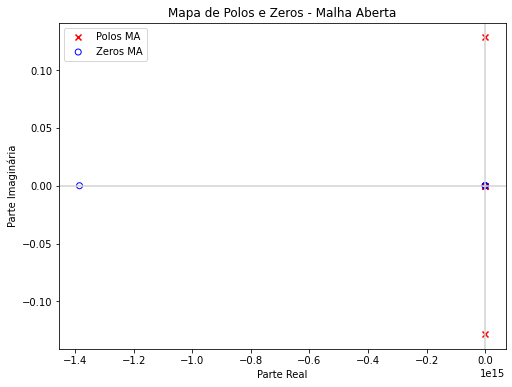

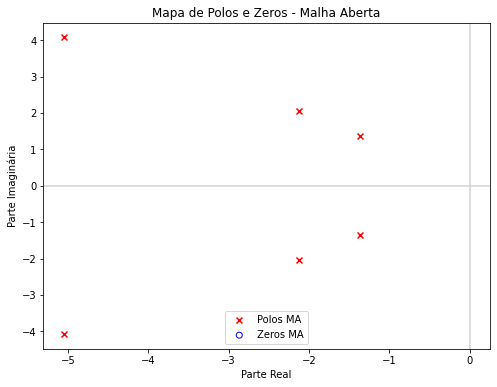

In [675]:
fig, ax = plt.subplots(figsize=(8,6))

# Polos: como 'x'
ax.scatter(poles_MA.real, poles_MA.imag, marker='x', color='red', label='Polos MA')

# Zeros: como 'o'
ax.scatter(zeros_MA.real, zeros_MA.imag, marker='o', facecolors='none', edgecolors='blue', label='Zeros MA')

ax.set_xlabel('Parte Real')
ax.set_ylabel('Parte Imaginária')
ax.set_title('Mapa de Polos e Zeros - Malha Aberta')
ax.grid(False)
ax.axhline(0, color='lightgrey', linestyle='-', linewidth=1.5)
ax.axvline(0, color='lightgrey', linestyle='-', linewidth=1.5)
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(8,6))

# Polos: como 'x'
ax.scatter(poles_LQR_MF.real, poles_LQR_MF.imag, marker='x', color='red', label='Polos MA')

# Zeros: como 'o'
ax.scatter(zeros_LQR_MF.real, zeros_LQR_MF.imag, marker='o', facecolors='none', edgecolors='blue', label='Zeros MA')

ax.set_xlabel('Parte Real')
ax.set_ylabel('Parte Imaginária')
ax.set_title('Mapa de Polos e Zeros - Malha Aberta')
ax.grid(False)
ax.axhline(0, color='lightgrey', linestyle='-', linewidth=1.5)
ax.axvline(0, color='lightgrey', linestyle='-', linewidth=1.5)
ax.legend()
plt.show()

### Simulação de resposta livre do sistema controlado

Índice de desempenho quadrático J: 1.598414


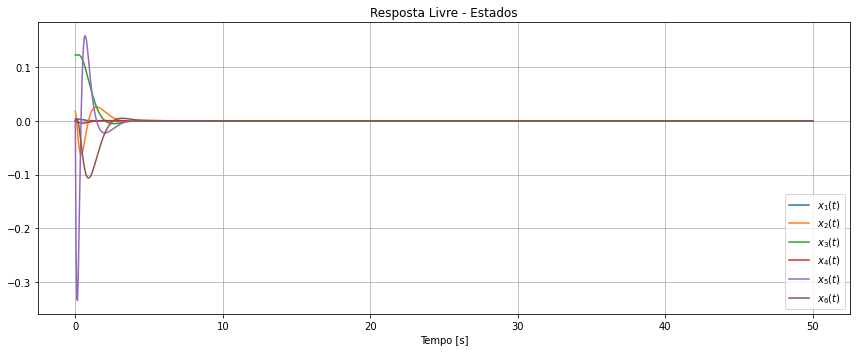

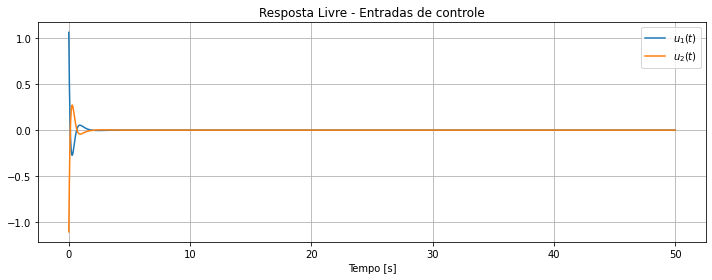

In [676]:
ts = np.linspace(0, 50, 1001)
w = np.zeros((E_num.shape[1], len(ts)))
x0 = [0.2*np.pi/180, np.pi/180, 7*np.pi/180, 0, 0, 0] ## ALTERÁVEL
t_livre, y_livre, x_livre = ct.forced_response(heli_LQR_MF, T=ts, X0=x0, return_x=True)

J = x0 @ P_LQR @ x0
print(f"Índice de desempenho quadrático J: {J:.6f}")

plt.figure(figsize=(12, 5))
for i in range(x.shape[0]):
    plt.plot(t_livre, x_livre[i, :], label=f"$x_{i+1}(t)$")
plt.title(f"Resposta Livre - Estados")
plt.xlabel("Tempo [s]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for i in range(y_livre.shape[0]):
    plt.plot(t_livre, y_livre[i, :], label=f"$u_{i+1}(t)$")
plt.title(f"Resposta Livre - Entradas de controle")
plt.xlabel("Tempo [s]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Simulação de resposta a perturbação de impulso em sistema controlado

Índice de desempenho quadrático J (via integração): 3.777803


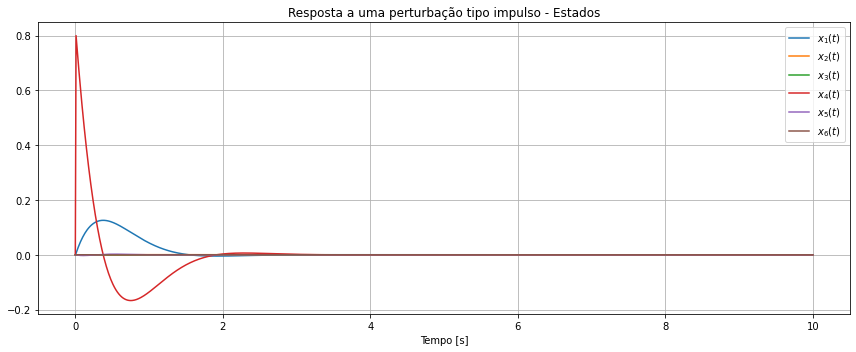

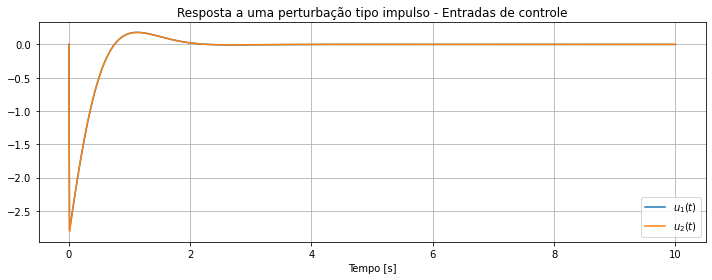

In [677]:
ts = np.linspace(0, 10, 1001)
x0 = np.zeros(6)

w_impulse = np.zeros((E_num.shape[1], len(ts)))
w_impulse[0, 0] = 1 / (ts[1] - ts[0])  # impulso aproximado como valor alto no primeiro passo

# Simulação com perturbação
t_imp, y_imp, x_imp = ct.forced_response(heli_LQR_MF, T=ts, U=w_impulse, X0=x0, return_x=True)

J_integral = 0
for i in range(len(t)):
    xi = x_imp[:, i]
    yi = y_imp[:, i]
    #print(type(xi), type(ui), type(Q), type(R))
    J_integral += (xi.T @ Q @ xi + yi.T @ R @ yi) * (t_imp[1] - t_imp[0])

print(f"Índice de desempenho quadrático J (via integração): {J_integral:.6f}")

# Plot dos estados
plt.figure(figsize=(12, 5))
for i in range(x_imp.shape[0]):
    plt.plot(t_imp, x_imp[i, :], label=f"$x_{i+1}(t)$")
plt.title("Resposta a uma perturbação tipo impulso - Estados")
plt.xlabel("Tempo [s]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot das entradas de controle
plt.figure(figsize=(10, 4))
for i in range(y_imp.shape[0]):
    plt.plot(t_imp, y_imp[i, :], label=f"$u_{i+1}(t)$")
plt.title("Resposta a uma perturbação tipo impulso - Entradas de controle")
plt.xlabel("Tempo [s]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()